In [5]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import time
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_diabetes, fetch_california_housing
import matplotlib.pyplot as plt

## Used Chatgpt to refine some parts of the function. References taken from:
1. Gonzalez, Teofilo F. “Clustering to Minimize the Maximum Intercluster Distance.” Proceedings of the Seventeenth Annual ACM Symposium on Theory of Computing, ACM, 1985.
2. Hochbaum, Dorit S., and David B. Shmoys. “A Best Possible Heuristic for the k-Center Problem.” Mathematics of Operations Research, vol. 10, no. 2, 1985.


In [6]:
def hochbaum_shmoys_original(X, k):
    # Computing distance matrix
    distances = pairwise_distances(X)
    n = len(distances)

    # Sorting unique distance values
    all_dists = np.unique(distances)
    all_dists = all_dists[all_dists > 0]  # removing zeros

    low, high = 0, len(all_dists) - 1
    best_radius = all_dists[-1]
    best_centers = None

    # Binary search for minimum feasible radius
    while low <= high:
        mid = (low + high) // 2
        R = all_dists[mid]

        # Step 3: Build adjacency for R
        adjacency = []
        for i in range(n):
            neigh = np.where(distances[i] <= 2*R)[0]
            neigh = neigh[neigh != i]  # remove self
            adjacency.append(set(neigh))

        # Step 4: Greedy dominating set
        uncovered = set(range(n))
        centers = []    

        while uncovered:
            v = next(iter(uncovered))
            centers.append(v)
            uncovered.discard(v)
            for u in adjacency[v]:
                uncovered.discard(u)

        # Feasibility check
        if len(centers) <= k:
            best_radius = R
            best_centers = centers[:k]
            high = mid - 1 
        else:
            low = mid + 1

    return best_centers, best_radius

In [7]:
def gonzalez_kcenter(X, k):
    n = len(X)
    centers = [np.random.randint(0, n)]
    distances = pairwise_distances(X, X[centers])[:, 0]

    start = time.time()
    while len(centers) < k:
        next_center = np.argmax(distances) # point farthest from current centers
        centers.append(next_center)
        newdist = pairwise_distances(X, X[[next_center]])[:, 0]
        distances = np.minimum(distances, newdist)
    end = time.time()

    cost = np.max(distances)
    return centers, cost, end - start



Dataset: Iris
HS Radius: 2.2452
HS Time: 0.0887
HS centers: [0, 41, 50, 53, 118]
Gonzalez Cost: 2.5708
Gonzalez Time: 0.0031
Gonzalez centers: [66, np.int64(15), np.int64(131), np.int64(41), np.int64(118)]

Dataset: Wine
HS Radius: 6.4222
HS Time: 0.0583
HS centers: [0, 59, 83, 121]
Gonzalez Cost: 6.4871
Gonzalez Time: 0.0012
Gonzalez centers: [58, np.int64(146), np.int64(115), np.int64(59), np.int64(121)]

Dataset: Breast Cancer
HS Radius: 11.206
HS Time: 0.8598
HS centers: [0, 10, 68, 71, 212]
Gonzalez Cost: 13.5958
Gonzalez Time: 0.0012
Gonzalez centers: [119, np.int64(152), np.int64(461), np.int64(9), np.int64(213)]

Dataset: Diabetes
HS Radius: 4.8801
HS Time: 0.3717
HS centers: [0, 1, 15, 117, 353]
Gonzalez Cost: 5.2454
Gonzalez Time: 0.006
Gonzalez centers: [382, np.int64(123), np.int64(441), np.int64(166), np.int64(422)]

Dataset: California Housing
HS Radius: 5.6384
HS Time: 0.3767
HS centers: [0, 50, 57, 91, 185]
Gonzalez Cost: 6.1061
Gonzalez Time: 0.0011
Gonzalez centers: 

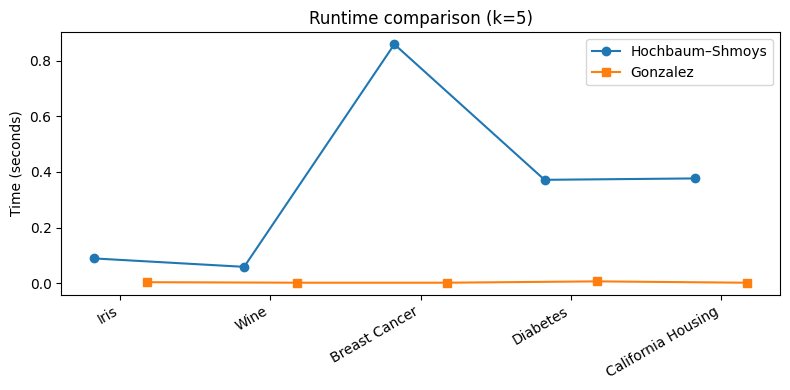

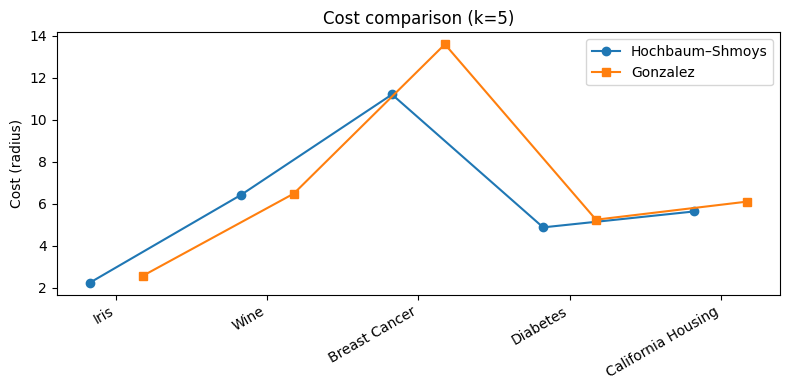

In [8]:
hs_times = []
g_times = []
hs_costs = []
g_costs = []
dataset_names = []

def run_all(name, X, k):
    print("\n========================")
    print("Dataset:", name)
    print("========================")

    X = StandardScaler().fit_transform(X)

    # Hochbaum–Shmoys
    start = time.time()
    hs_centers, hs_radius = hochbaum_shmoys_original(X, k)
    hs_time = time.time() - start

    # González
    g_centers, g_cost, g_time = gonzalez_kcenter(X, k)

    print("HS Radius:", round(2*hs_radius, 4))
    print("HS Time:", round(hs_time, 4))
    print("HS centers:", hs_centers)
    print("Gonzalez Cost:", round(g_cost, 4))
    print("Gonzalez Time:", round(g_time, 4))
    print("Gonzalez centers:", g_centers)

    # store for plotting
    hs_times.append(hs_time)
    g_times.append(g_time)
    hs_costs.append(2*hs_radius)
    g_costs.append(g_cost)
    dataset_names.append(name)


datasets = [
    ("Iris", load_iris().data),
    ("Wine", load_wine().data),
    ("Breast Cancer", load_breast_cancer().data),
    ("Diabetes", load_diabetes().data),
    ("California Housing", fetch_california_housing().data[:400])
]

for name, data in datasets:
    run_all(name, data, k=5)

x = np.arange(len(dataset_names))
width = 0.35

plt.figure(figsize=(8, 4))
plt.plot(x - width/2, hs_times,  'o-', label='Hochbaum–Shmoys')
plt.plot(x + width/2, g_times, 's-', label='Gonzalez')

plt.xticks(x, dataset_names, rotation=30, ha='right')
plt.ylabel("Time (seconds)")
plt.title("Runtime comparison (k=5)")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8, 4))
plt.plot(x - width/2, hs_costs,  'o-', label='Hochbaum–Shmoys')
plt.plot(x + width/2, g_costs, 's-', label='Gonzalez')

plt.xticks(x, dataset_names, rotation=30, ha='right')
plt.ylabel("Cost (radius)") 
plt.title("Cost comparison (k=5)")
plt.legend()    
plt.tight_layout()

plt.show()

